# Matlab data loading and processing

In [1]:
import os
import numpy as np
import scipy.io
from gudhi.representations.preprocessing import BirthPersistenceTransform, DiagramScaler
from sklearn.preprocessing import MaxAbsScaler
from sklearn.cluster import KMeans
from sklearn.pipeline import Pipeline, make_pipeline
from preprocessing import *
from persistent_bow import *
from visualization import *

In [2]:
data_path = "./pd.mat"
data_mat = scipy.io.loadmat(data_path)
data = data_mat["pds"]

In [3]:
data.shape # Here are 50 diagrams (rows), 7 types(cols) = 350 diagrams

(50, 7)

In [4]:
data[0][1].shape # each diagram has n rows and 2 colums # here we get first diagram from type "1"

(23, 2)

In [5]:
# y - labels - type of diagram [0-7]
# We transpose to iterate over diagram list
y = []
for label, diagram_list in enumerate(data.T):
    y += len(diagram_list) * [label]
y = np.array(y)

# data.T = 2d array of diagrams as row, column as type
X = data.T.reshape(-1)

In [6]:
pipe = make_pipeline(BirthPersistenceTransform(), 
               DiagramScaler(use=True, 
                             scalers=[
                                 ((0,), MaxAbsScaler(copy=False)),
                                 ((1,), MaxAbsScaler(copy=False))]))

In [7]:
preprocessed = np.array(pipe.fit_transform(X, y))

# Different classes codebooks visualization

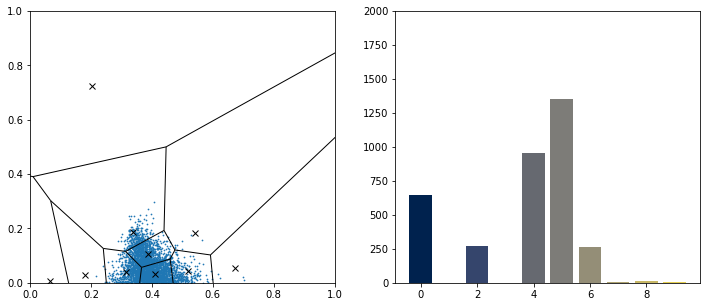

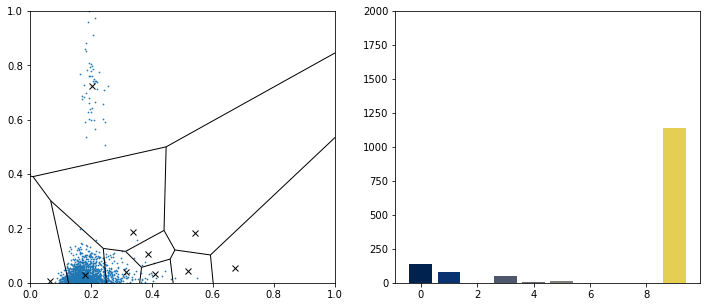

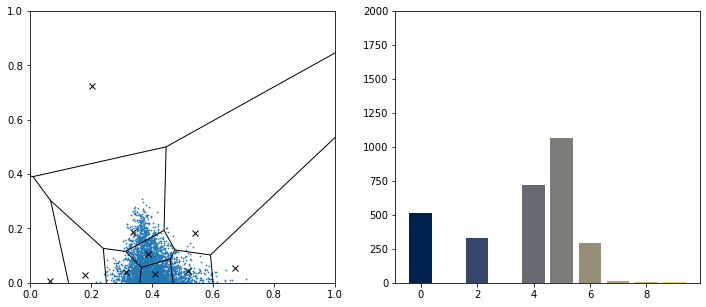

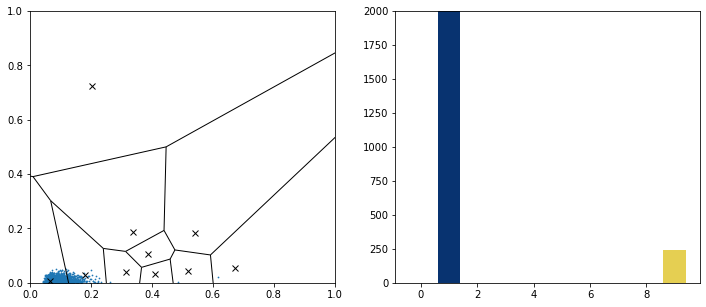

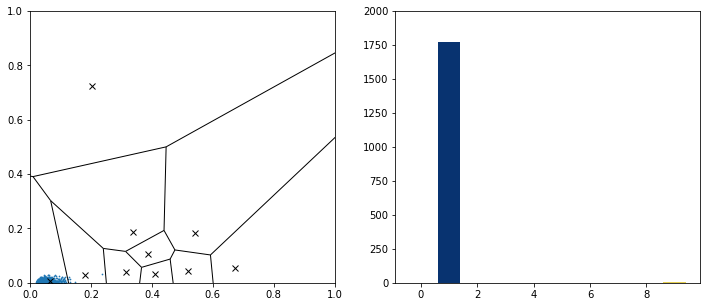

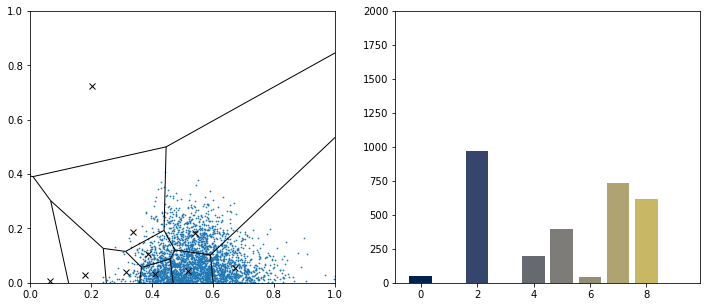

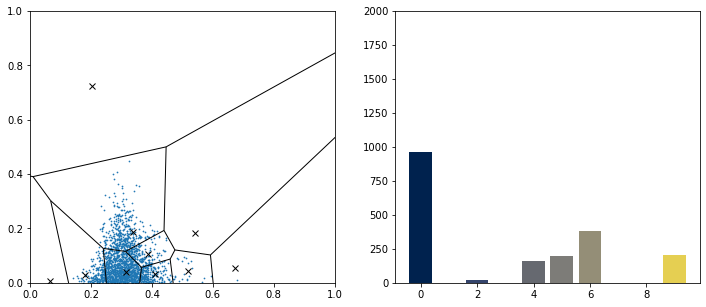

In [8]:
vectorizer = PersistentBow(KMeans(10), transformator=None, scaler=None)
vectorizer.fit(preprocessed)

for label in np.unique(y):    
    class_X = preprocessed[y==label]
    joined_X = np.concatenate(class_X)
    bow = vectorizer.transform([joined_X])[0]
    
    plt.figure(figsize=(12,5))
    ax = plt.subplot(121)
    plot_voronoi(vectorizer.cluster, ax=ax)
    ax.scatter(joined_X[:, 0], joined_X[:, 1], s=0.5)
    ax = plt.subplot(122)
    plot_bow(bow, 2000, ax=ax)

# Visualization of different weighting functions for sampler

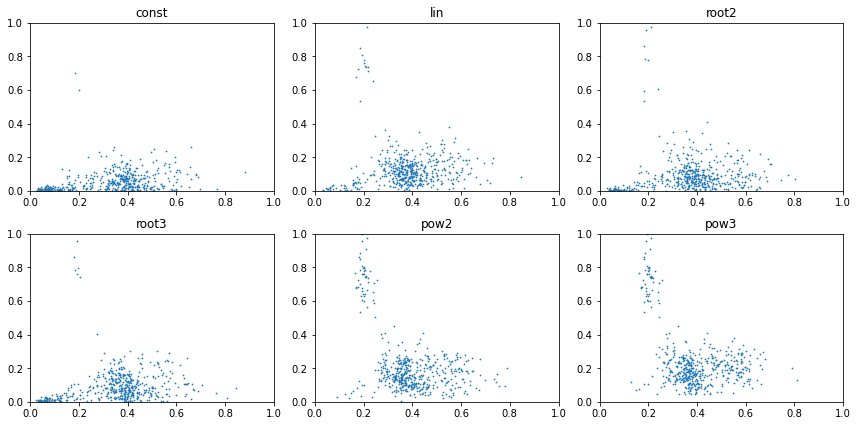

In [9]:
#Different persistence weighting functions visualization
sampling_weights = {
    "const":None,
    "lin" : lambda x : x,
    "root2" : lambda x : x**(1/2),
    "root3" : lambda x : x**(1/2),
    "pow2" : lambda x : x**2,
    "pow3" : lambda x : x**3,
}

index = 1
plt.figure(figsize=(12,6))

for name, weight in sampling_weights.items():
    transformed = RandomPDSampler(500, weight).fit_transform(preprocessed, y)[0]
    
    ax = plt.subplot(2,3,index)
    ax.set_title(name)
    ax.scatter(transformed[:, 0], transformed[:, 1], s=0.5)
    ax.set_ylim(0,1)
    ax.set_xlim(0,1)
    
    index += 1
    
plt.tight_layout(pad=1.0)

# Model comparison
## First step: Model hyperparameter optimization

In [10]:
import sklearn
import joblib
import pandas as pd
from sklearn.cluster import KMeans, MiniBatchKMeans
from sklearn.model_selection import train_test_split, cross_validate,cross_val_score, StratifiedKFold, GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.svm import SVC, LinearSVC
from sklearn.mixture import GaussianMixture
from gudhi.representations.kernel_methods import SlicedWassersteinKernel
from gudhi.representations.vector_methods import PersistenceImage
from gudhi.representations.metrics import BottleneckDistance

#Fast hack to make SlicedWassersteinKernel scikit-compliant
setattr(SlicedWassersteinKernel, "get_params",
        lambda self, deep: {
            "bandwidth":self.bandwidth,
            "num_directions" : self.sw_.num_directions
        })

In [11]:
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)
fold = StratifiedKFold(5, shuffle=True, random_state=42)
splits = np.array([split for split in fold.split(X, y)])

In [12]:
#Helper function, constructs final pipeline and returns girdsearch for it
def make_final_grid(estimator, param_grid, *args, **kwargs ):
    new_param_grid = {f"Model__{name}" : values for name, values in param_grid.items()}
    new_param_grid["Predictor__C"] = [0.1, 1, 10]
    
    final_pipeline = Pipeline([
        ("Model", estimator),
        ("Predictor", SVC(kernel="linear", max_iter=1e6))
    ])
    
    return GridSearchCV(final_pipeline, new_param_grid, cv = splits, *args, **kwargs)

In [13]:
#PBoW gridsearch
pbow_gridsearch = make_final_grid(
    estimator = PersistentBow(KMeans(7, n_init=1, max_iter=100, random_state=42),
                              sampler=RandomPDSampler(2500)),
    param_grid = {
        "cluster__n_clusters" : np.arange(10, 200, 10),
        "sampler__max_points" : np.arange(1000, 13000, 1000),
        "sampler__weight_function" : [None, lambda x : x, lambda x : x**2]
    },
    n_jobs = -1
)

#SPBoW gridsearch
spbow_gridsearch = make_final_grid(
    estimator = StablePersistentBow(GaussianMixture(random_state=42),
                              sampler=RandomPDSampler(2500)),
    param_grid = {
        "mixture__n_components" : np.arange(10, 200, 10),
        "sampler__max_points" : np.arange(1000, 13000, 1000),
        "sampler__weight_function" : [None, lambda x : x, lambda x : x**2]
    },
    n_jobs = -1
)

# PBOW with KMeans from VLFeat # TODO: This is Vl kmeans are 2 functions only
# We need to wrap it with something what fits fit, transform API
# pbow_on_stereoids = pbow_pipeline = Pipeline([
#     ("pbow",  PersistentBow(Vlkmeans(7,2), sampler=RandomPDSampler(2500)))
# ])


#SlicedWassersteinKernel gridsearch
swk_gridsearch = make_final_grid(
    estimator = SlicedWassersteinKernel(),
    param_grid = {
        "bandwidth" : [0.05, 0.1, 0.25, 0.5, 1, 1.5, 2],
        "num_directions" : [5, 10, 15, 20, 25]
    },
    n_jobs = -1    
)

#BottleneckDistance gridsearch
bd_gridsearch = make_final_grid(
    estimator = BottleneckDistance(),
    param_grid = {
        "epsilon" : [None, 1e-8]
    },
    n_jobs = -1  
)

#PersistenceImage gridsearch
pi_gridsearch = make_final_grid(
    estimator = PersistenceImage(),
    param_grid = {
        "bandwidth" : [0.1, 0.25, 0.5, 1, 1.5],
        "weight" : [lambda x : 1, lambda x : x[1], lambda x : x[1]**2], #x=(birth, persistence)
        "resolution" : [(10,10), (20,20), (40,40), (50, 50)],
    },
    n_jobs = -1
)

models_to_test = {
    "PBoW" : pbow_gridsearch, 
    "SPboW" : spbow_gridsearch,
    "SWK" : swk_gridsearch, 
    "Bottleneck" : bd_gridsearch,
    "PersistenceImage" : pi_gridsearch
}

In [14]:
import pathlib
import dill
import os

#helper functions for serialized objects 

def load(path):
    if os.path.exists(path):
        with open(path, "br") as f:
            return dill.load(f)
    
    return None

def save(obj, path):
    folder = os.path.dirname(path)
    if not os.path.exists(folder):
        os.mkdir(folder)
        
    with open(path, "bw") as f:
        dill.dump(obj, f)
        

In [15]:
for name, grid in models_to_test.items():
    print(name)
    grid_path = f"precomputed/grid/{name}.dill"
    
    out = load(grid_path)
    if out:
        print("Loaded from file")
        models_to_test[name] = out
    else:
        grid.verbose = 10
        grid.fit(X, y)
        save(grid, grid_path)

PBoW
Loaded from file
SPboW
Loaded from file
SWK
Loaded from file
Bottleneck
Loaded from file
PersistenceImage
Loaded from file


## Comparison of best estimators

In [16]:
grid_path = "precomputed/grid"
cv_path = "precomputed/cv"

for filename in os.listdir(grid_path):
    name = os.path.splitext(filename)[0]
    grid = load(os.path.join(grid_path, filename))
    results = load(os.path.join(cv_path, filename))
    
    if not results:
        print("Computing", name)
        model = grid.best_estimator_
        results = cross_validate(model, X, y, cv=splits)
        save(results, os.path.join(cv_path, f"{name}.dill"))
    

Computing PersistenceLandscape


In [17]:
for filename in os.listdir(grid_path):
    name = os.path.splitext(filename)[0]
    grid = load(os.path.join(grid_path, filename))
    results = load(os.path.join(cv_path, filename))
    
    print(name, "Mean scores:")
    df = pd.DataFrame(results)
    print(df.mean())

Bottleneck Mean scores:
fit_time      96.502984
score_time    48.328631
test_score     0.860000
dtype: float64
PBoW Mean scores:
fit_time      0.526825
score_time    0.053769
test_score    0.945714
dtype: float64
PersistenceImage Mean scores:
fit_time      0.243982
score_time    0.031980
test_score    0.960000
dtype: float64
PersistenceLandscape Mean scores:
fit_time      2.304442
score_time    0.567936
test_score    0.891429
dtype: float64
SPboW Mean scores:
fit_time      1.416370
score_time    0.147638
test_score    0.954286
dtype: float64
SWK Mean scores:
fit_time      4.684789
score_time    2.314275
test_score    0.977143
dtype: float64


In [18]:
base_path = "precomputed/cv"
for filename in os.listdir(base_path):
    path = os.path.join(base_path, filename)
    name = os.path.splitext(filename)[0]
    
    print(name)
    results = load(path)
    print(name, "Mean scores:")
    df = pd.DataFrame(results)
    print(df.mean())

Bottleneck
Bottleneck Mean scores:
fit_time      96.502984
score_time    48.328631
test_score     0.860000
dtype: float64
PBoW
PBoW Mean scores:
fit_time      0.526825
score_time    0.053769
test_score    0.945714
dtype: float64
PersistenceImage
PersistenceImage Mean scores:
fit_time      0.243982
score_time    0.031980
test_score    0.960000
dtype: float64
PersistenceLandscape
PersistenceLandscape Mean scores:
fit_time      2.304442
score_time    0.567936
test_score    0.891429
dtype: float64
SPboW
SPboW Mean scores:
fit_time      1.416370
score_time    0.147638
test_score    0.954286
dtype: float64
SWK
SWK Mean scores:
fit_time      4.684789
score_time    2.314275
test_score    0.977143
dtype: float64


## Listing  of best parameters for each model

In [19]:
for name, grid in models_to_test.items():
    print(name, "Best parameters:")
    grid_params = grid.param_grid.keys()
    model = grid.best_estimator_
    for param_name in grid_params:
        param = model.get_params()[param_name]
        print(f'{param_name} :', param)
    print()

PBoW Best parameters:
Model__cluster__n_clusters : 40
Model__sampler__max_points : 10000
Model__sampler__weight_function : None
Predictor__C : 1

SPboW Best parameters:
Model__mixture__n_components : 50
Model__sampler__max_points : 6000
Model__sampler__weight_function : <function <lambda> at 0x000001E69269A3A8>
Predictor__C : 10

SWK Best parameters:
Model__bandwidth : 0.1
Model__num_directions : 10
Predictor__C : 1

Bottleneck Best parameters:
Model__epsilon : None
Predictor__C : 10

PersistenceImage Best parameters:
Model__bandwidth : 0.1
Model__weight : <function <lambda> at 0x000001E69269A708>
Model__resolution : (10, 10)
Predictor__C : 1



## Plot - PBoW accuracy vs n_clusters

In [ ]:
best_max_points = models_to_test["PBoW"].best_params_["Model__sampler__max_points"]
best_n_clusters = models_to_test["PBoW"].best_params_["Model__cluster__n_clusters"]
best_weight = models_to_test["PBoW"].best_params_["Model__sampler__weight_function"]

result_list = []
n_clusters_range = np.arange(10, 200, 10)
# Fix seed for sampler
np.random.seed(0)
for n_clusters in n_clusters_range:
    final_pipeline = Pipeline([
        ("pbow",  PersistentBow(KMeans(n_clusters, n_init=1, max_iter=100, random_state=42),
                                sampler=RandomPDSampler(best_max_points, best_weight))),
        ("Predictor", SVC(kernel="linear"))
    ])
    
    results = cross_val_score(final_pipeline, X, y, cv=splits)
    result_list.append(np.mean(results))
    
plt.plot(n_clusters_range, result_list)

## Plot - PBoW accuracy vs sampler max_points

In [ ]:
best_max_points = models_to_test["PBoW"].best_params_["Model__sampler__max_points"]
best_n_clusters = models_to_test["PBoW"].best_params_["Model__cluster__n_clusters"]
best_weight = models_to_test["PBoW"].best_params_["Model__sampler__weight_function"]

result_list = []
max_points_range = np.arange(1000, 13000, 1000)
# Fix seed
np.random.seed(0)
for max_points in max_points_range:
    final_pipeline = Pipeline([
        ("pbow",  PersistentBow(KMeans(best_n_clusters, n_init=1, max_iter=100, random_state=42), 
                                sampler=RandomPDSampler(max_points, best_weight))),
        ("Predictor", SVC(kernel="linear"))
    ])
    
    results = cross_val_score(final_pipeline, X, y, cv=splits)
    result_list.append(np.mean(results))
    
plt.plot(max_points_range, result_list)